In [1]:
import numpy as np
import os
import csv
import igl
import math
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
import geopandas as gpd
import plotly.graph_objects as go
import ripleyK as rk

In [2]:
# Read the shapefile
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "ocean")
path = os.path.join(folder_path, "ne_10m_ocean.shp")
ocean = gpd.read_file(path)

#ocean.plot(color='red', edgecolor='black', figsize=(15,15))

In [3]:
# csv file location
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "Whale")

path = os.path.join(folder_path, "Antarctic blue whales, east Antarctic sector of the Southern Ocean-reference-data.csv")
with open(path, 'r') as file:
    csvreader = csv.reader(file)
    data = []
    for row in csvreader:
        data.append(row)
    data = np.array(data)

# read all csv files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            csvreader = csv.reader(file)
            for row in csvreader:
                # Append the row to the data array, skipping the header row
                if csvreader.line_num > 1:
                    data = np.vstack((data, np.array(row)))

# write the data to a csv file
with open('Whale.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)


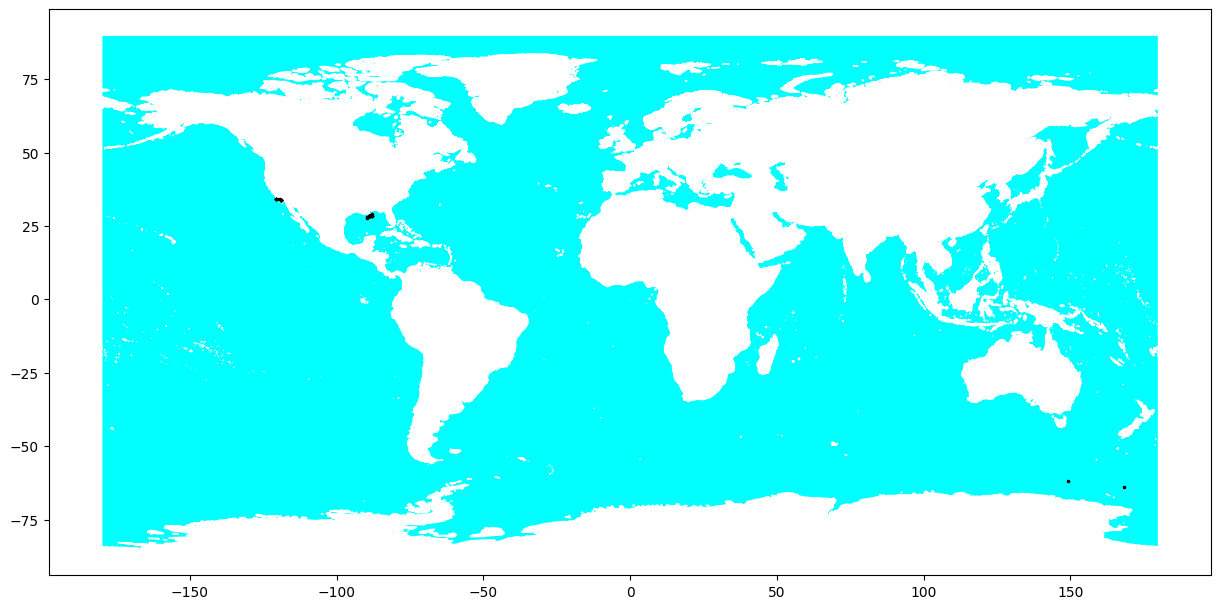

In [4]:
long = data[1:,41]
lat = data[1:,40]
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(long, lat))

ocean.plot(color='cyan', edgecolor='white', figsize=(15,15))
points.plot(ax=plt.gca(), color='black', markersize=2)
plt.savefig('ocean.png')

In [5]:
# get the longitude and latitude
print(data.shape)
long = data[1:,41]
lat = data[1:,40]

#remove the duplicates
sample = zip(long, lat)
sample = [*set(sample)]
sample = list(zip(*sample))

# convert to polar coordinates
long = np.array(sample[0], dtype=float)
lat = np.array(sample[1], dtype=float)

def longConvert(long):
    for i in range(len(long)):
        if long[i] < 0:
            long[i] = 360 + long[i]
    return long

lat = 90 - lat # north pole is 90, south pole is -90, convert to 0 to 180
long = longConvert(long) # convert to 0 to 360

# convert to radians
long = np.deg2rad(long)
lat = np.deg2rad(lat)
# convert to cartesian coordinates
r = 1
x = r*np.cos(long)*np.sin(lat)
y = r*np.sin(long)*np.sin(lat)
z = r*np.cos(lat)



(73, 73)


In [6]:
def sample_faces(vertices, faces, num_samples):
    # calculate the area of each triangle
    a = vertices[faces[:, 0]]
    b = vertices[faces[:, 1]]
    c = vertices[faces[:, 2]]
    areas = np.linalg.norm(np.cross(b-a, c-a), axis=1) / 2

    # normalize areas to get probability distribution
    probabilities = areas / np.sum(areas)

    # randomly choose triangles to sample from
    face_indices = np.random.choice(len(faces), size=num_samples, p=probabilities)

    # generate random points within each selected triangle
    u = np.random.rand(num_samples, 1)
    v = np.random.rand(num_samples, 1)
    w = 1 - u - v
    a = vertices[faces[face_indices, 0]]
    b = vertices[faces[face_indices, 1]]
    c = vertices[faces[face_indices, 2]]
    points = u * a + v * b + w * c

    return points

In [9]:
vertices, faces = igl.read_triangle_mesh(os.path.join(current_dir, "mesh", "ocean_mesh_500_simplified.obj"))

vx, vy, vz = vertices.T
fi, fj, fk = faces.T
points_uniform = sample_faces(vertices, faces, 100)



mesh = go.Mesh3d(x=vx, y=vy, z=vz, i=fi, j=fj, k=fk, color='blue', opacity=0.5)
samples_whale = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color='black'))
samples_uniform = go.Scatter3d(x=points_uniform[:, 0], y=points_uniform[:, 1], z=points_uniform[:, 2], mode='markers', marker=dict(size=2, color='red'))

fig = go.Figure(data=[mesh, samples_whale, samples_uniform])
fig.show()

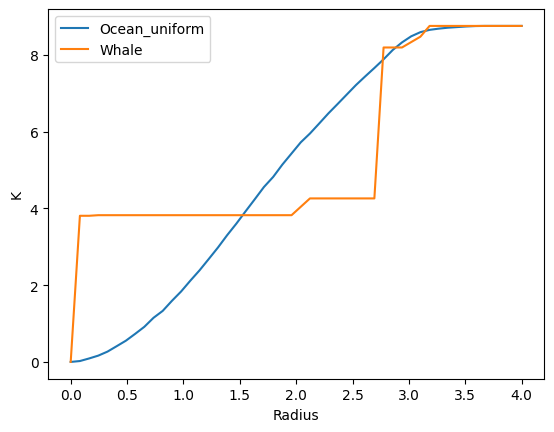

In [10]:
radii = np.linspace(0, 4, 50)
samples_whale = np.vstack((x, y, z)).T

kt_whale_mesh = rk.ripleyK_mesh(vertices, faces, samples_whale, radii)
kt_ocean_uniform = rk.ripleyK_mesh(vertices, faces, points_uniform, radii)
# kt_whale_gcd = rk.ripleyK(1, samples_whale, radii)
# plt.axvline(x=math.pi, color='black', linestyle='--', label=u"\u0960")
plt.plot(radii, kt_ocean_uniform, label='Ocean_uniform')
plt.plot(radii, kt_whale_mesh, label='Whale')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()